In [43]:
# Import packages
import numpy as np
import pandas as pd
from fastai.vision.all import *

In [44]:
# Import image labels
df = pd.read_csv('images/labels.csv')
df.head()

,files,labels
0,IMG_3788.JPEG,sweetclem
1,IMG_3789.JPEG,sweetclem
2,IMG_3790.JPEG,sweetclem
3,IMG_3791.JPEG,sweetclem
4,IMG_3792.JPEG,sweetclem


In [45]:
# Setup image transforms
tfms = aug_transforms(size=224,flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [46]:
# Load image data from image labels and jpg files
dls = ImageDataLoaders.from_df(df, 'images', valid_pct=0.2, label_delim=' ',
                               item_tfms=Resize(224), bs=20, batch_tfms=tfms)
dls.valid_ds.items

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


,files,labels
30,IMG_3818.JPEG,braeburn
47,IMG_3835.JPEG,royal_gala
109,braeburn13.jpg,braeburn
52,IMG_3840.JPEG,royal_gala braeburn
102,braeburn06.jpg,braeburn
35,IMG_3823.JPEG,braeburn
129,pink_lady01.jpg,pink_lady
108,braeburn12.jpg,braeburn
130,pink_lady02.jpg,pink_lady
136,pink_lady08.jpg,pink_lady


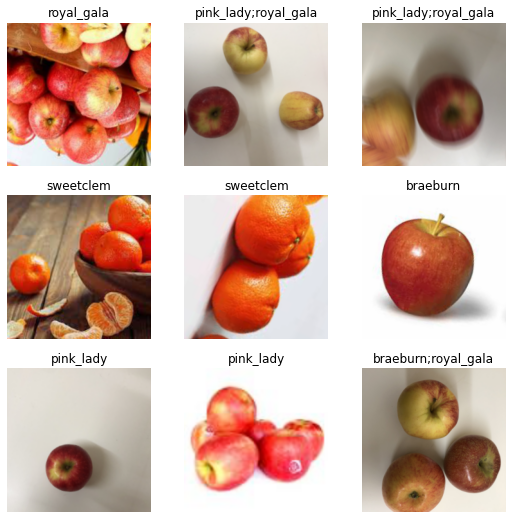

In [47]:
# Preview data
dls.show_batch()

In [48]:
# Init learner; use resnet50 as the starting point for this CNN
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

SuggestedLRs(valley=0.0008317637839354575)

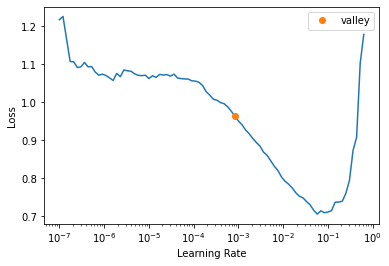

In [49]:
# Calc optimal learning rate
learn.lr_find()

In [50]:
# Train model
learn.fine_tune(5, 8e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.004591,0.728346,0.583333,00:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.738363,0.728452,0.601852,00:48
1,0.683967,0.646588,0.694444,00:48
2,0.653841,0.570929,0.740741,00:48
3,0.630242,0.509283,0.759259,00:48
4,0.580528,0.491832,0.777778,00:49


SuggestedLRs(valley=9.120108734350652e-05)

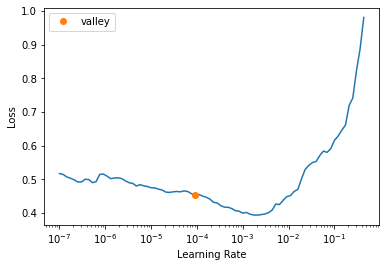

In [51]:
# Calc optimal learning rate
learn.lr_find()

In [52]:
# Train model
learn.fine_tune(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.464233,0.476946,0.796296,00:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.482159,0.494985,0.777778,00:51
1,0.480874,0.497820,0.805556,00:54
2,0.486126,0.481437,0.787037,00:54
3,0.473849,0.488430,0.768519,00:53
4,0.466709,0.475443,0.777778,00:52


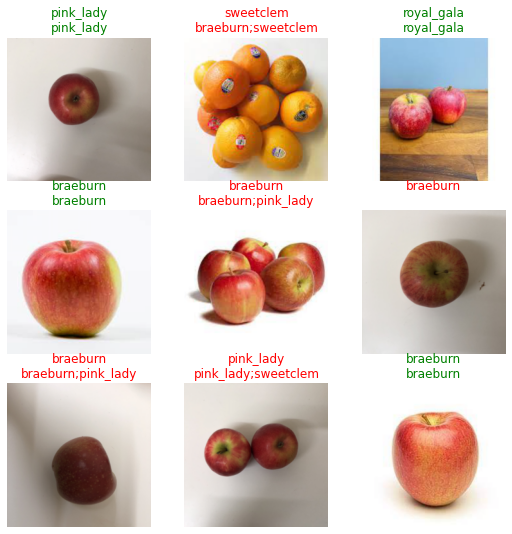

In [53]:
# Preview results
learn.show_results()